In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import wind_force, vector_to_xy_components, get_mass_matrix
import pandas as pd

In [ ]:
current_velocity = IntegratedWhiteNoise(0, 0.514, 0.1, 0.001)
current_direction = IntegratedWhiteNoise(0, 360, 100, 1)
wind_velocity = IntegratedWhiteNoise(0, 7.716, 2, 2)
wind_direction = IntegratedWhiteNoise(0, 360, 200, 7)

wind = np.zeros((5, 100))
for i in range(100):
    wind[0, i] = wind_velocity.get_value()
    wind[1, i] = wind_direction.get_value()
    vec = vector_to_xy_components(wind[0, i], wind[1, i])
    wind[2:, i] = wind_force(vec, wind[1, i], np.array([0, 0, 0]))

pd.DataFrame(wind)

In [38]:
mass_inv = np.linalg.inv(get_mass_matrix())
mass_inv.dot(get_mass_matrix())

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [68]:
h = 0.01
it = 1000

vel = np.zeros((3, it))
pos = np.zeros((3, it))

for i in range(it-1):
    v = wind_velocity.get_value()
    d = wind_direction.get_value()
    vec = vector_to_xy_components(v, d)
    f = wind_force(vec, d, vel[:, i])
    force = np.array([100, 0, 0])
    vel[:, i+1] = vel[:, i] + h * mass_inv.dot(force + f)
    
    pos[:, i+1] = pos[:, i] + h * vel[:, i]

print(vel.shape)
vel[:, 900:]

(3, 1000)


array([[1.98094094, 1.9829005 , 1.9848605 , 1.98681901, 1.98877796,
        1.99073679, 1.99270599, 1.994671  , 1.99663912, 1.99862627,
        2.00061216, 2.00261145, 2.00462358, 2.00672487, 2.00886395,
        2.01096056, 2.01300479, 2.01504683, 2.01710876, 2.01920403,
        2.02130065, 2.02335411, 2.02540314, 2.02748644, 2.02951969,
        2.03152047, 2.03355103, 2.03555367, 2.03754147, 2.03951005,
        2.04148438, 2.0434633 , 2.04543833, 2.04740319, 2.04937168,
        2.05133422, 2.0532933 , 2.05526403, 2.0572533 , 2.05927316,
        2.06135511, 2.06343826, 2.06548411, 2.06752411, 2.06956241,
        2.07161157, 2.07370791, 2.07578015, 2.0778163 , 2.07983785,
        2.08183428, 2.08383828, 2.08583866, 2.08785971, 2.08985775,
        2.09183417, 2.09381177, 2.09578873, 2.09778046, 2.0997707 ,
        2.10174719, 2.10373107, 2.10570659, 2.10769096, 2.10966648,
        2.11164286, 2.11362612, 2.11558845, 2.11755551, 2.11951978,
        2.12149556, 2.12347631, 2.12543637, 2.12

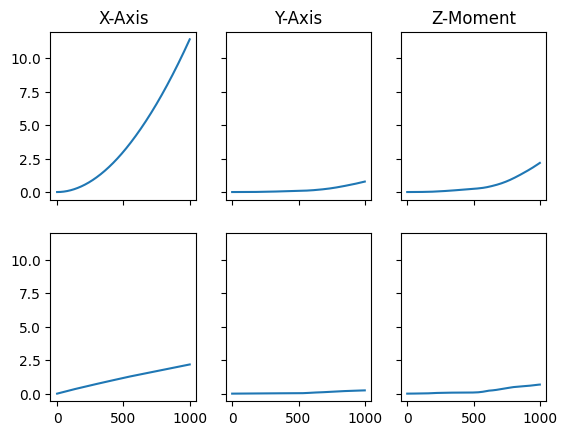

In [83]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
ax[0, 0].plot(range(it), pos[0, :])
ax[0, 1].plot(range(it), pos[1, :])
ax[0, 2].plot(range(it), pos[2, :])
ax[1, 0].plot(range(it), vel[0, :])
ax[1, 1].plot(range(it), vel[1, :])
ax[1, 2].plot(range(it), vel[2, :])
ax[0, 0].set_title('X-Axis')
ax[0, 1].set_title('Y-Axis')
ax[0, 2].set_title('Z-Moment')

plt.show()